## 对时间序列做分类任务，识别异常（不同于ARIMA回归模型）

#### tsfresh可以自动提取特征

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

# https://github.com/blue-yonder/tsfresh
# http://tsfresh.readthedocs.io/en/latest/text/quick_start.html

C:\Users\LOMO\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\LOMO\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 老版本
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,a,b,c,d,e,f
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [4]:
# 新版本(此数据集是远程加载)
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()
# F_x F_y F_z T_x.... 为传感器上的指标

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [15]:
df.tail()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5
1319,88,14,-13,2,15,-25,-25,6


In [18]:
import pandas as pd
pd.set_option('max_rows',14)
y

1      True
2      True
3      True
4      True
5      True
6      True
7      True
      ...  
82    False
83    False
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

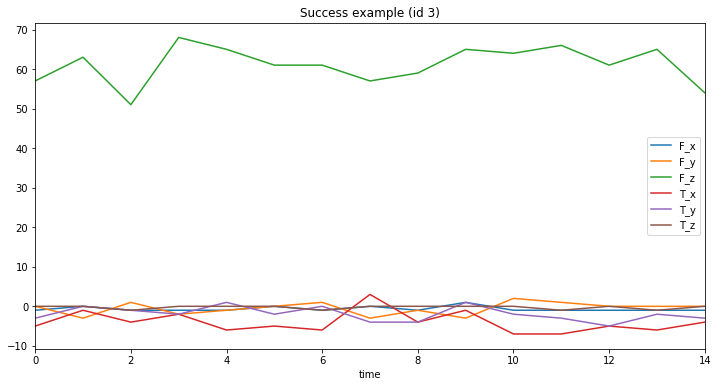

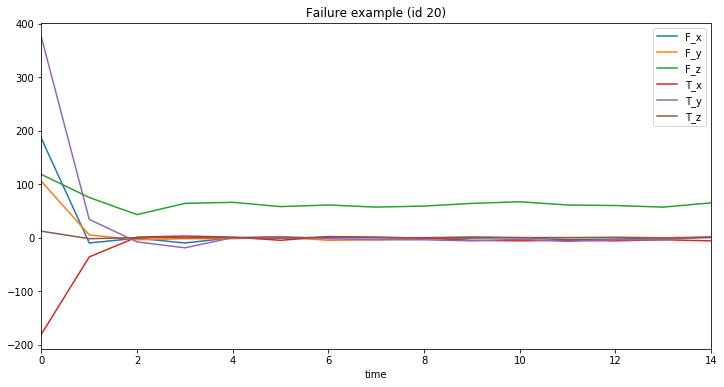

In [6]:
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

In [8]:
extraction_settings = ComprehensiveFCParameters() #基于时间序列进行特征的提取

In [9]:
#column_id (str) – The name of the id column to group by
#column_sort (str) – The name of the sort column.
X = extract_features(df, 
                     column_id='id', column_sort='time', # 以id为聚合，以时间序列为排序
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...,
 'T_z__fft_coefficient__coeff_9__attr_"imag"'
 'T_z__fft_coefficient__coeff_9__attr_"real"'
 'T_z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [10]:
X.head()
# 4764个特征

variable,F_x__abs_energy,F_x__absolute_sum_of_changes,"F_x__agg_autocorrelation__f_agg_""mean""","F_x__agg_autocorrelation__f_agg_""median""","F_x__agg_autocorrelation__f_agg_""var""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,T_z__time_reversal_asymmetry_statistic__lag_1,T_z__time_reversal_asymmetry_statistic__lag_2,T_z__time_reversal_asymmetry_statistic__lag_3,T_z__value_count__value_-inf,T_z__value_count__value_0,T_z__value_count__value_1,T_z__value_count__value_inf,T_z__value_count__value_nan,T_z__variance,T_z__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1,14.0,2.0,-0.106351,-7.206633e-02,0.016879,0.0,-1.0,-1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,15.0,0.0,0.0,0.0,0.000000,0.0
2,25.0,14.0,-0.039098,-4.935275e-02,0.088790,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,11.0,0.0,0.0,0.0,0.195556,0.0
3,12.0,10.0,-0.029815,1.301043e-17,0.105435,1.0,-1.0,-2.0,0.0,0.0,...,0.000000,-0.090909,0.000000,0.0,11.0,0.0,0.0,0.0,0.195556,0.0
4,16.0,17.0,-0.049773,-6.417112e-02,0.143580,1.0,-1.0,-1.0,0.0,0.0,...,0.000000,-0.181818,0.000000,0.0,8.0,1.0,0.0,0.0,0.355556,0.0
5,17.0,13.0,-0.061467,-5.172414e-02,0.052642,2.0,-1.0,-2.0,0.0,0.0,...,-0.076923,-0.090909,-0.222222,0.0,9.0,2.0,0.0,0.0,0.382222,0.0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 4764 entries, F_x__abs_energy to T_z__variance_larger_than_standard_deviation
dtypes: float64(4764)
memory usage: 3.2 MB


In [19]:
X_filtered = extract_relevant_features(df, y,  # 对特征进行再过滤
                                       column_id='id', column_sort='time', 
                                       default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...,
 'T_z__fft_coefficient__coeff_9__attr_"imag"'
 'T_z__fft_coefficient__coeff_9__attr_"real"'
 'T_z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [22]:
print(X_filtered.shape)
X_filtered.head() # X_filtered为最后提取的特征

(88, 623)


variable,F_x__abs_energy,F_x__range_count__max_1__min_-1,F_y__abs_energy,T_y__standard_deviation,T_y__variance,"F_x__fft_coefficient__coeff_1__attr_""abs""","T_y__fft_coefficient__coeff_1__attr_""abs""",T_y__abs_energy,F_z__standard_deviation,"F_z__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""",...,T_z__large_standard_deviation__r_0.35000000000000003,T_z__quantile__q_0.9,"F_z__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","T_x__agg_autocorrelation__f_agg_""mean""","F_y__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8",T_x__spkt_welch_density__coeff_5,"T_y__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","F_y__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","F_z__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","F_z__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4"
id,,,,,,,,,,,,,,,,,,,,,
1,14.0,15.0,13.0,0.471405,0.222222,1.000000,1.165352,10.0,1.203698,0.65,...,0.0,0.0,62.833333,-0.095589,0.209184,0.037795,-1.000000,0.000000,63.0,0.000000
2,25.0,13.0,76.0,2.054805,4.222222,0.624118,6.020261,90.0,4.333846,19.84,...,1.0,0.0,64.666667,-0.054604,0.000000,0.319311,-1.000000,0.222222,70.0,2.666667
3,12.0,14.0,40.0,1.768867,3.128889,2.203858,8.235442,103.0,4.616877,22.01,...,1.0,0.0,67.333333,-0.061050,0.000000,9.102780,-3.000000,0.250000,68.0,8.187500
4,16.0,10.0,60.0,2.669998,7.128889,0.844394,12.067855,124.0,3.833188,10.64,...,0.0,0.0,63.666667,-0.133794,1.555556,56.910262,-3.166667,1.360000,66.0,1.000000
5,17.0,13.0,46.0,2.039608,4.160000,2.730599,6.445330,180.0,4.841487,16.00,...,0.0,0.6,64.333333,-0.106108,0.000000,22.841805,-4.166667,1.040000,67.0,0.000000


In [23]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 623 entries, F_x__abs_energy to F_z__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4
dtypes: float64(623)
memory usage: 429.0 KB


### 上面将id为1-88的6个时间序列的特征提取出来后，再用分类器进行分类

In [24]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)

In [29]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

      False       0.97      1.00      0.98        28
       True       1.00      0.88      0.93         8

avg / total       0.97      0.97      0.97        36



In [33]:
cl.n_features_  # 4764为未进行再次特征提取的特征数量

4764

In [34]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

             precision    recall  f1-score   support

      False       0.97      1.00      0.98        28
       True       1.00      0.88      0.93         8

avg / total       0.97      0.97      0.97        36



In [35]:
cl2.n_features_ # 623为进行再次特征提取的特征数量

623